# Sequential Bayesian Learning (SBL)
## Authors:  Author: Robert Tjarko Lange, Miro Grundei, Sam Gjisem
## Last Update: December 2018

# 0. General Introduction to the project

In this project we investigate the theoretical modelling of mismatch-negativity in the human somatosensory cortex. More specifically, we study a novel roving paradigm which is generated from a structured graphical model. This allows us to define standard and deviant stimuli in stimulus-feature-independent manner. Furthermore, sampling (as opposed to deterministic sequence generation) enables us to control for sequence-dependent cofounding factors.

The following notebook is structured as follows:

- ** 1. Generation of Trial Sequences based on Graphical Model**.
    * We formulate a general Markov model which generates a sequence of trials (0 - low intensity, 0.5 - catch trial, 1 - high intensity)
    * The alternation probability between different observations depends upon the previous observed states as well as the hidden state/regime which is modeled as a Markov Chain.
    * We are able to increase the order of the Markov dependency in the data-generating process. This allows to vary the complexity of the sequence generation.
    
    
- **2. Modeling of different Sequential Bayesian Learning Agents**.
    * The agents process the trial sequence as it comes in. Based on different probabilistic models they update there current posterior estimate about the hidden state that drives the sampling of the observed state. 
    * Based on her current posterior estimate, we can calculate different surprise measures (e.g. Predictive, Bayesian as well as Confidence-Corrected). These surprise measures indicate how well the agent is able to infer the data-generating mechanism and the corresponding hidden states.
    * Going forward we will combine the data-generating paradigm and surprise measures with frequency data obtained from an EEG study. Thereby, we will be able to compare different models with different degrees of complexity of somatosensory adaptation and learning.
    
    
- **3. Model Comparison across Different SBL Agents and Surprise Regressors**
    * Evaluation of theoretical models in explaining the EEG frequency variation.

In [ ]:
!pip install -r requirements.txt --quiet

In [1]:
# Import relevant sampling modules
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [6]:
import os
import numpy as np

from utils.helpers import *
from utils.plotting import *

import sampling.seq_gen as sg
import sampling.seq_analysis as sa

# Import relevant SBL modules
import sbl_agents.sbl_cat_dir as sbl_cd
import sbl_agents.sbl_hmm as sbl_hmm

# Set random seed for replicability and define directories
np.random.seed(seed=1234)
results_dir = os.getcwd() + "/results/"
fig_dir = os.getcwd() + "/figures/"
data_dir = os.getcwd() + "/data/"

# 1. Generation of Trial Sequence based on Graphical Model

Our sampling paradigm is motivated by the classical roving paradigm. In such a setting a deviant is defined relative to the previous trials.

Depending on whether or not we account for second order Markov dependency also $o_{t-2}$ influences the sampling probabilities. Our generating process can be described by the following graphical model:

<img src="figures/gm_seq_gen.png" alt="drawing" width="750"/>

* Catch: $p(o_t = 0.5) = 0.05$
* Regime switch: $p(s_t \neq s_{t-1}) = 0.01$

Sample a sequence from the Graphical Model and saves it to .mat file
* 1st order Markov sequence of length 800 with following probabilities:
    * Regime 0: $p(o_t = 0|o_{t-1}=0, s_t=0), p(o_t = 1|o_{t-1}=0, s_t=0)$
    * Regime 1: $p(o_t = 0|o_{t-1}=0, s_t=1), p(o_t = 1|o_{t-1}=0, s_t=1)$
```
pythonw seq_gen.py -t 1st_temp -reg_init 0.5 -reg_change 0.01 -catch 0.05 -obs_init 0.5 -obs_change 0.35 0.65 0.65 0.35 -order 1 -v -seq
800
```

* 2nd order Markov sequence of length 800 with following probabilities:
    * Regime 0: $p(o_t = 0|o_{t-1}=0, o_{t-1}=0) = 0.35, p(o_t|o_{t-1}) = 0.65$
    * Regime 1: $p(o_t = 0|o_{t-1}=0) = 0.65, p(o_t|o_{t-1}) = 0.35$
```
pythonw seq_gen.py -t 1st_temp -reg_init 0.5 -reg_change 0.01 -catch 0.05 -obs_init 0.5 -obs_change 0.35 0.65 0.65 0.35 -order 2 -v -seq
800
```

In [3]:
# Define parameters for sequence sampling
prob_regime_init = np.array([0.5, 0.5])  # Prob. vector for inital regime (hidden state)
prob_regime_change = 0.01  # Prob. of sampling a regime change
prob_obs_init = np.array([0.5, 0.5, 0])  # Prob. vector for inital trial/stimulus (observed state)
prob_obs_change = [0.45, 0.45, 0.05, 0.05, 0.05, 0.05, 0.45, 0.45]  # Prob. matrix for different regimes
prob_catch = 0.05  # Prob. of sampling a catch trial (independent of hidden state)

order = len(prob_obs_change)/4  # Markov order/lag dependency in the sampling scheme
seq_length = 200  # Length of sampled sequence
sample_file = "S1_200"  # Title of file saved
matlab_out = True  # Boolean - store file as .mat - otherwise .pkl file
plot_seq = True  # Booelean - plot the sampled sequence
verbose = True  # Print out the transition prob. specification and empirical statistics of the sampled seq
plot_seqs = True

In [4]:
# Create instance of sampling class
gen_temp = sg.seq_gen(order, prob_catch, prob_regime_init, prob_regime_change,
                      prob_obs_init, prob_obs_change, verbose)

All input arrays conform with the specified dimensions.
HHMM correctly initialized. Ready to Sample.
--------------------------------------------
2nd Order Transition Prob. 
 Regime 0: p(0|00)=0.45, p(0|01)=0.45, p(0|10)=0.05,  p(0|11)=0.05 
 Regime 1: p(0|00)=0.05, p(0|01)=0.05, p(0|10)=0.45,  p(0|11)=0.45
--------------------------------------------


Empirical Probabilities: 
 Empirical Catch Prob.: 0.05 
 Empirical Regime Switch Prob.: 0.03 
 Empirical Overall High-Intensity Stimulus Prob.: 0.7315789473684211 
 Empirical Regime 0 High-Intensity Stimulus Prob.: 0.8823529411764706 
 Empirical Regime 1 High-Intensity Stimulus Prob.: 0.6987179487179487 
 Empirical Regime 0 Alternation Prob.: 0.17142857142857143 
 Empirical Regime 1 Alternation Prob.: 0.6129032258064516  
 JS Div. Deviant Waiting Time Distr. between Regimes: 0.1808679351465925 
 Time in Regime 0: 0.175 
 Average Train Length in Regime 0: 3.7777777777777777 
 Average Train Length in Regime 1: 1.6185567010309279
--------------------------------------------


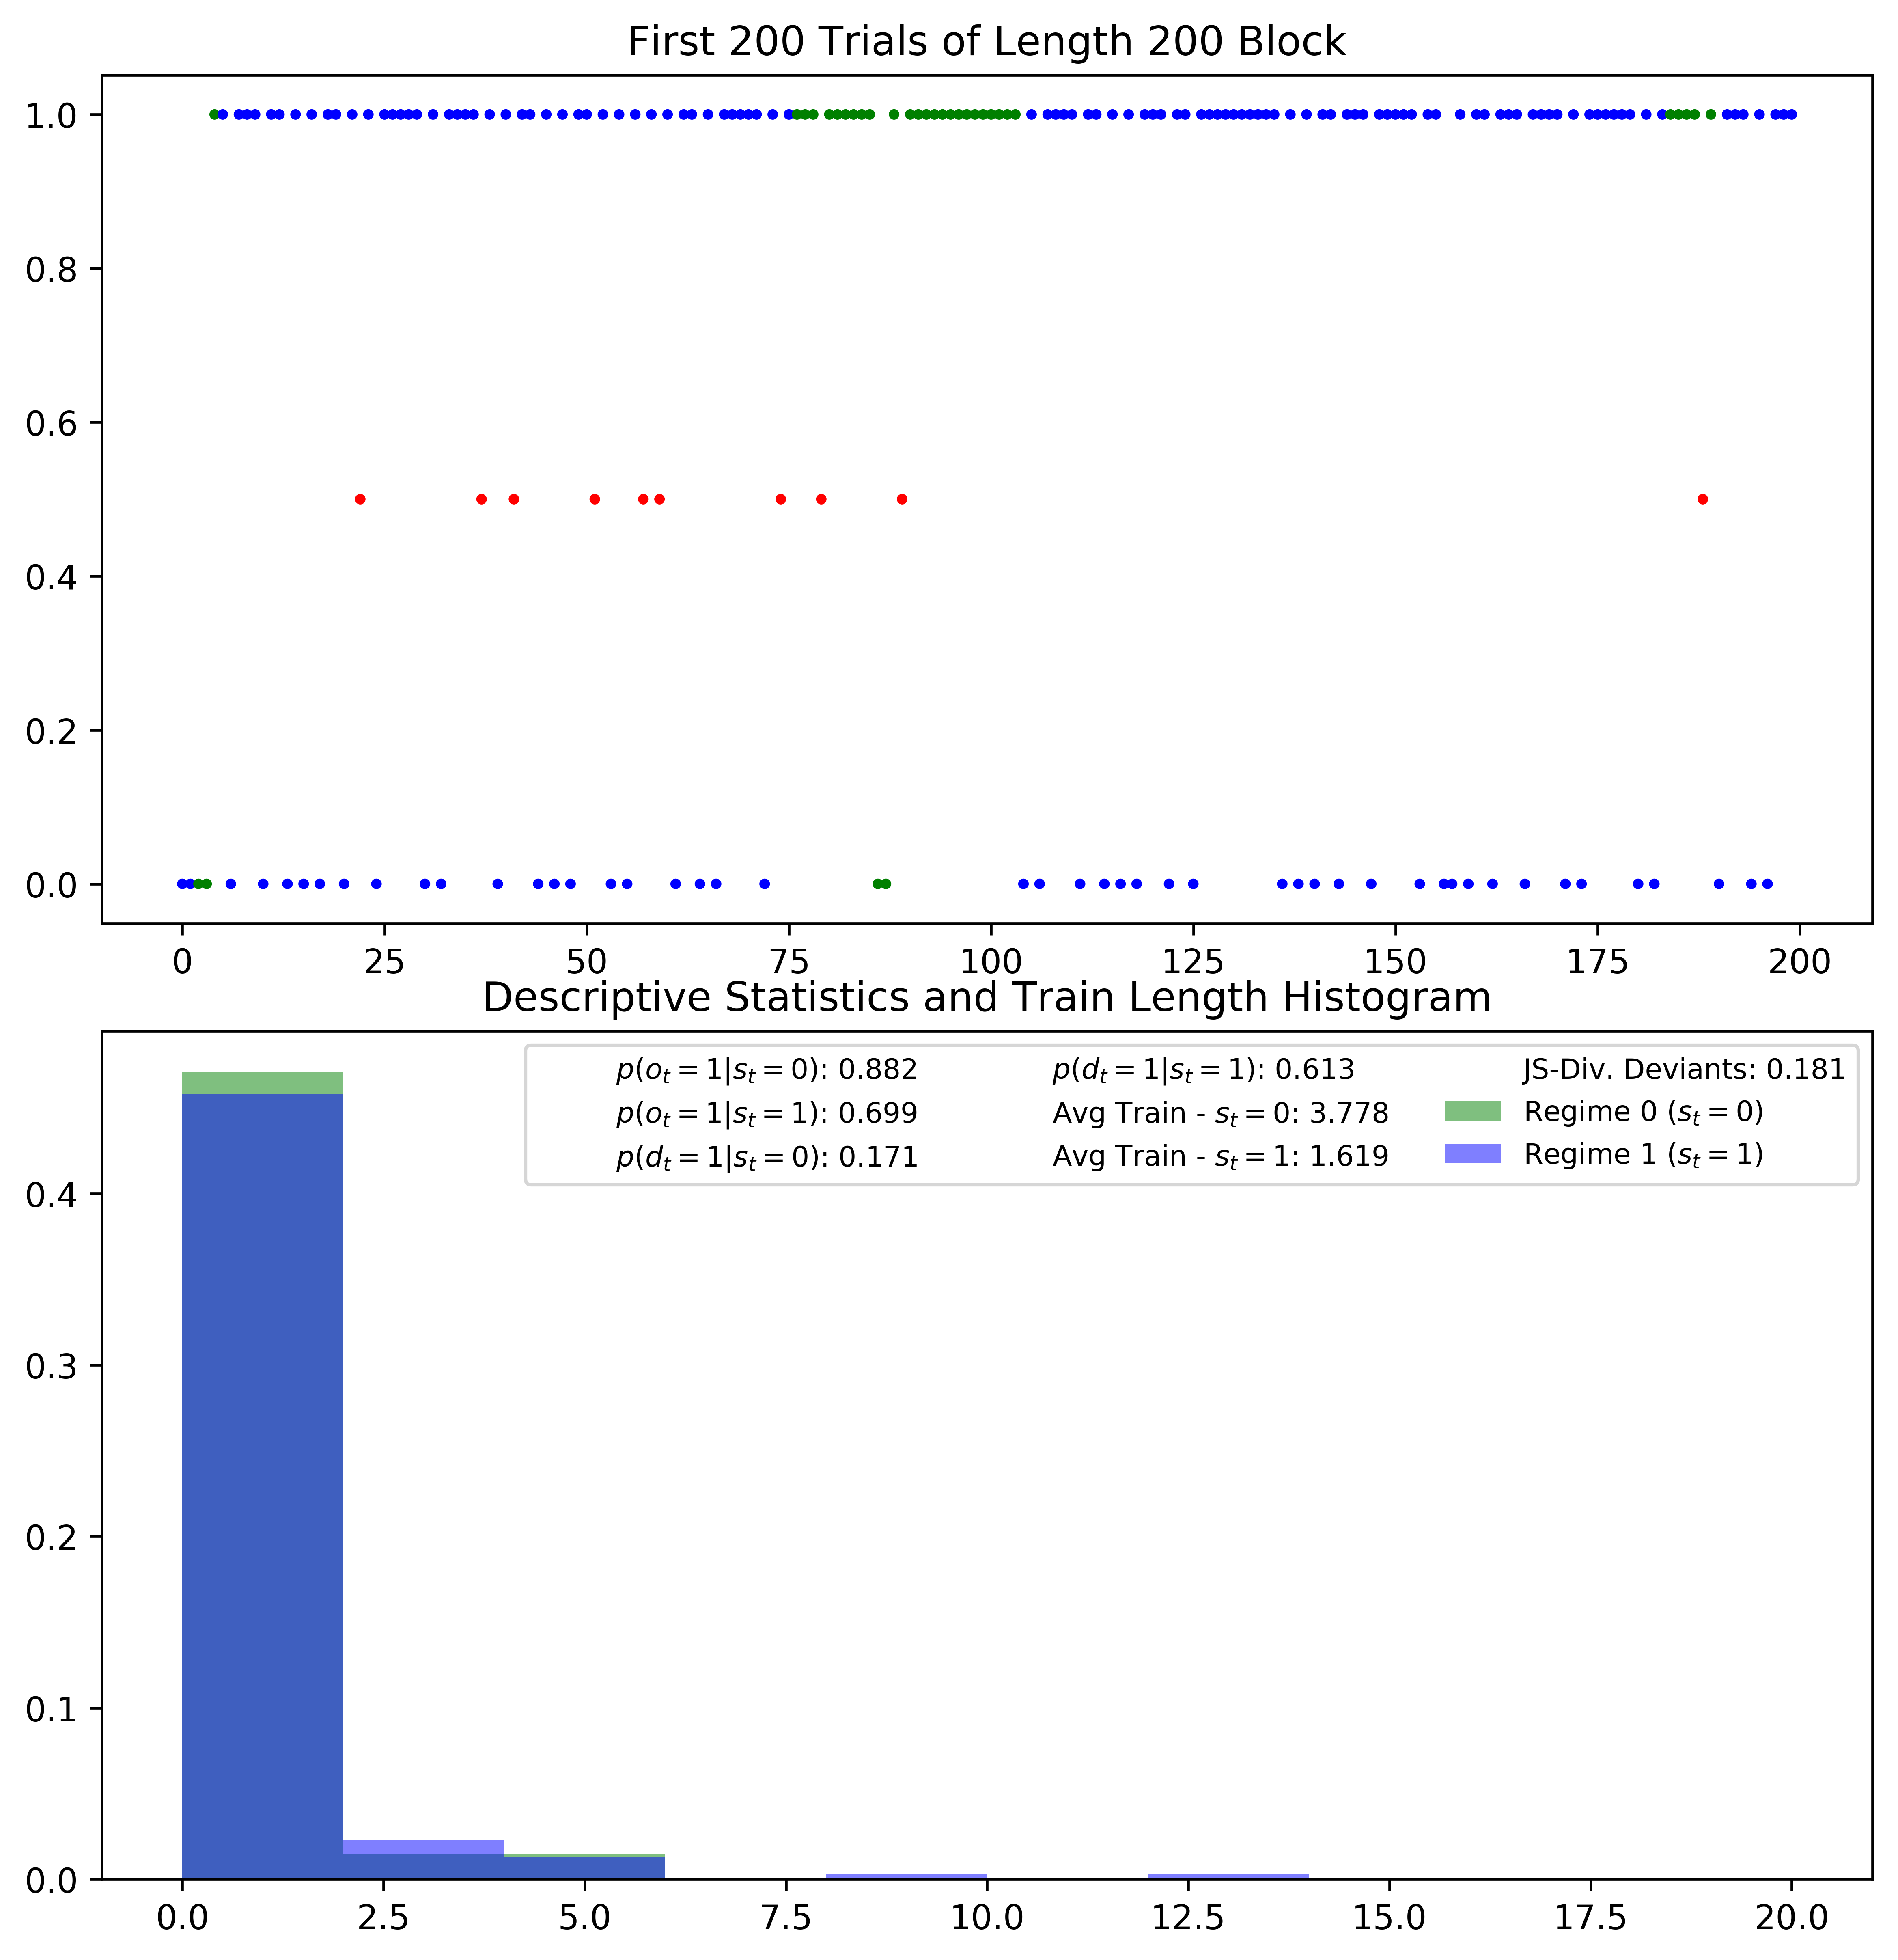

In [5]:
# sequence = gen_temp.sample(seq_length)
# Plot the sampled sequence - when exec from command line
sg.sample_and_save(gen_temp, seq_length, sample_file,
                   matlab_out, plot_seq)

In [ ]:
if plot_seqs:
    sa.main(order=1, verbose=False, plot=True, save=False)

In [ ]:
if plot_seqs:
    sa.main(order=2, verbose=False, plot=True, save=False)

# 2. Modeling of different Sequential Bayesian Learning Agents

In [7]:
sample_files = [["sub-01_ses-1_run-1", "sub-01_ses-1_run-2",
                 "sub-01_ses-1_run-3", "sub-01_ses-1_run-4",
                 "sub-01_ses-1_run-5"]]

In [8]:
sample, meta = load_obj("data/" + sample_files[0][0] + ".mat")

seq = sample[:, 2]
hidden = sample[:, 1]

prob_regime_init = meta["prob_regime_init"]
prob_obs_init = meta["prob_obs_init"]
prob_obs_change = meta["prob_obs_change"]
prob_regime_change = meta["prob_regime_change"]

In [9]:
# General Model Settings
model_types = ["SP", "AP", "TP"]
save_results = True
verbose = True

## 2.1. Conjugate Categorical-Dirichlet Model

In [10]:
tau = 0.

In [11]:
# Test agents by calculating posterior after 3 timesteps
# and Surprises for t=1,2,3
for model in model_types:
    sbl_cd.test_agent(seq, hidden, tau, model, verbose)

---------------------------------------------
SP: Dirichlet-Distribution after 3 timestep: alphas = [3. 2. 1.]
SP: Computing different surprisal measures for 3 timesteps.
SP - t=1: PS=0.6931, BS=0.2359, CS=2.6146
SP - t=2: PS=0.5108, BS=0.1402, CS=3.9198
SP - t=3: PS=1.0986, BS=0.4739, CS=5.1507
SP: Done computing surprisal measures for all 800 timesteps.
---------------------------------------------
AP: Dirichlet-Distribution after 3 timestep: alphas = [2. 3.]
AP: Computing different surprisal measures for 3 timesteps.
Can't update posterior with only one observation - need two!
AP - t=1: PS=0.6931, BS=0.2349, CS=0.2416
AP - t=2: PS=0.6931, BS=0.2082, CS=1.2224
AP - t=3: PS=0.9163, BS=0.1402, CS=1.807
AP: Done computing surprisal measures for all 800 timesteps.
---------------------------------------------
TP: Dirichlet-Distribution after 3 timestep: alphas = [[2. 2. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
TP: Computing different surprisal measures for 3 timesteps.
Can't update posterior with on

In [12]:
for model in model_types:
    sbl_cd.main(seq, hidden, tau, model,
                prob_regime_init, prob_obs_init, prob_obs_change,
                prob_regime_change,
                save_results, title="CD_" + model + "_" + sample_file,
                verbose=True)

SP: Computing different surprisal measures for 800 timesteps.
SP: Done computing surprisal measures for all 800 timesteps.
Saved in File: /Users/rtl/Dropbox/PHD_ECN/LAB_ROTATION_1_BLANKENBURG/CODE/SBL/results/CD_SP_S1_200
AP: Computing different surprisal measures for 800 timesteps.
Can't update posterior with only one observation - need two!
AP: Done computing surprisal measures for all 800 timesteps.
Saved in File: /Users/rtl/Dropbox/PHD_ECN/LAB_ROTATION_1_BLANKENBURG/CODE/SBL/results/CD_AP_S1_200
TP: Computing different surprisal measures for 800 timesteps.
Can't update posterior with only one observation - need two!
TP: Done computing surprisal measures for all 800 timesteps.
Saved in File: /Users/rtl/Dropbox/PHD_ECN/LAB_ROTATION_1_BLANKENBURG/CODE/SBL/results/CD_TP_S1_200


In [13]:
SP_CD = load_obj(results_dir + "CD_" + "SP" + "_" + sample_file + ".pkl")
AP_CD = load_obj(results_dir + "CD_" + "AP" + "_" + sample_file + ".pkl")
TP_CD = load_obj(results_dir + "CD_" + "TP" + "_" + sample_file + ".pkl")

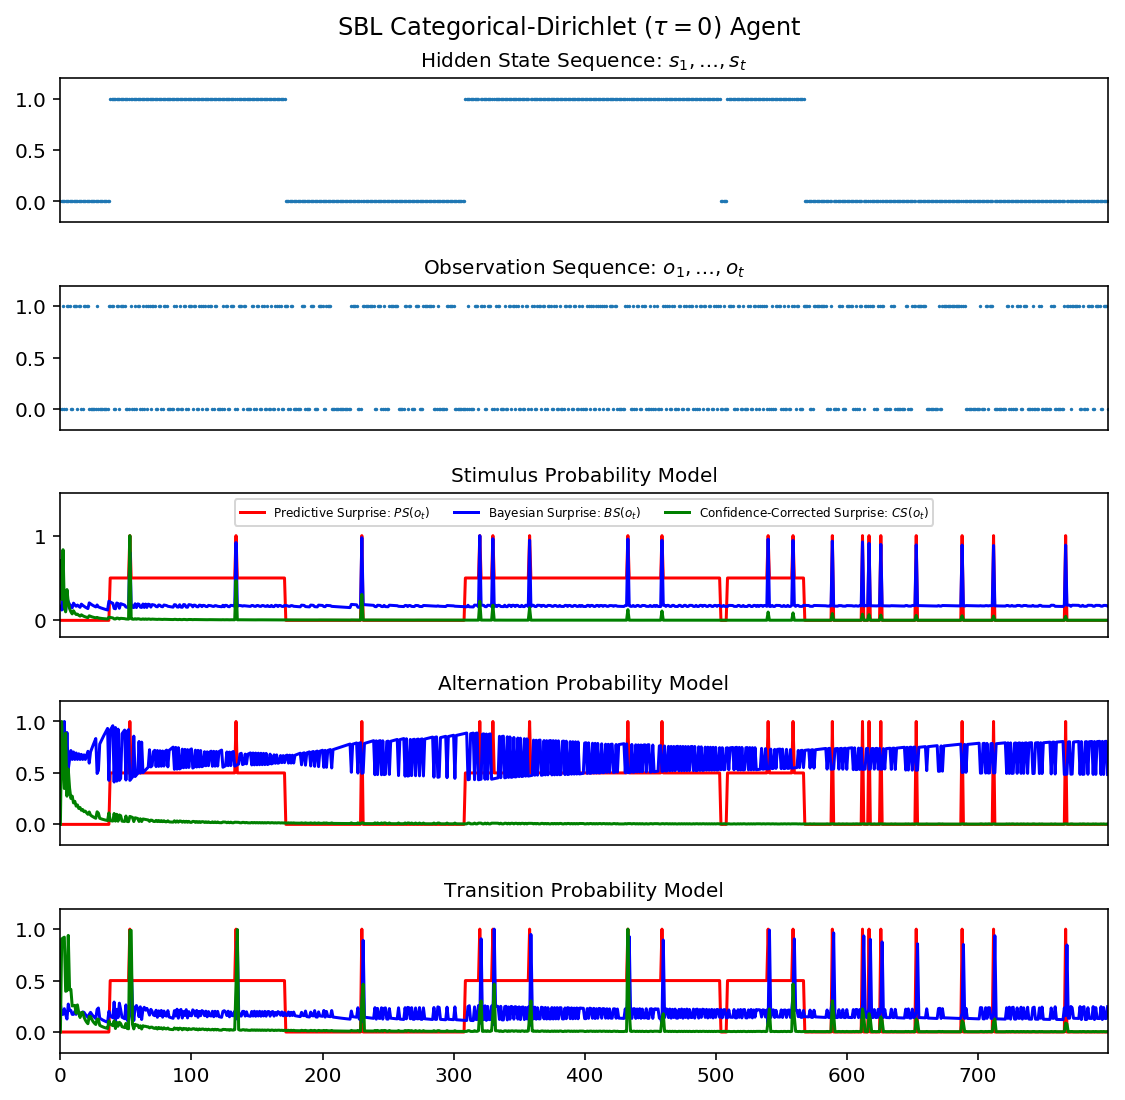

In [14]:
plot_surprise(SP_CD, AP_CD, TP_CD,
              title=r"Categorical-Dirichlet ($\tau = 0$)",
              save_pic=False)

## 2.2. Hidden Markov Model

In [ ]:
n_states = 2

In [ ]:
# Test agents by calculating posterior after 3 timesteps
# and Surprises for t=1,2,3
for model in model_types:
    sbl_hmm.test_agent(seq, hidden, n_states, model, verbose)

## 3. Model Comparison across Different SBL Agents and Surprise Regressors

In [4]:
sample_files = [["sub-01_ses-1_run-1", "sub-01_ses-1_run-2",
                 "sub-01_ses-1_run-3", "sub-01_ses-1_run-4",
                 "sub-01_ses-1_run-5"]]

In [7]:
# Get Regressors ready!
sample, meta = load_obj("data/" + sample_files[0][0] + ".mat")
seq = sample[:, 2]
hidden = sample[:, 1]
PS, BS, CS = sbl_cd.main(seq, hidden, tau=0, model_type="TP")

TP: Computing different surprisal measures for 800 timesteps.
Can't update posterior with only one observation - need two!
TP: Done computing surprisal measures for all 800 timesteps.


In [8]:
# Load in EEG Dataset
eeg_files = ["sub-01_sbl"]
eeg_data = sio.loadmat("data/" + eeg_files[0] + ".mat")

In [116]:
def get_electrode_data(eeg_data, block_id, elec_id):
    num_blocks = 5
    num_trials = 4000
    # Subselect eeg and recording time stamps from raw data object in .mat file
    """
    Structure of eeg_raw/eeg_times object: Sampling rate of 512 points per second
        - raw: Num rows = number of blocks, Num cols = Number of electrodes (see EOI)
        - times: Num rows = number of trials and start of blocks (last rows)
    """
    eeg_raw = eeg_data["data"][0]
    eeg_time = eeg_data["data"][1]
    # Select data according to block and electrode id
    elec_bl_raw = eeg_raw[block_id][elec_id]
    eeg_bl_time = eeg_time[block_id].flatten()
    
    # Select block-specific event times from from raw data in .mat file
    """
    Structure of event_times object: Rows 1-4000: Events/Trials
        First Col: Boolean for Bad Quality Trial
        Second Col: Form of stimulus/trial see trial_coding_lookup object
        Third Col: Time of trial - use to match with elec_bl_raw to get data
        
    block_start_times: Final rows of event_times yield the starting times of blocks
        - use to subselect specific data with the help of the trial times
    """
    event_times = eeg_data["event_times"][0]
    event_times = np.array(event_times.tolist()).reshape((num_trials+num_blocks, 3))
    block_start_times = []
    
    for i in range(len(event_times[num_trials:])):
        block_start_times.append(event_times[num_trials:][i][2])
    # Append final point in time and sanity check
    block_start_times.append(event_times[num_trials-1][2])
    if len(block_start_times) != (num_blocks + 1):
        raise "Something is wrong with data shape: Wrong number of blocks!"
    
    time_int = block_start_times[block_id:block_id+2]
    start_idx = np.where(event_times[:, 2] > time_int[0])
    stop_idx = np.where(event_times[:, 2] < time_int[1])
    block_event_idx = np.intersect1d(start_idx, stop_idx)
    # Select event times based on start/stop of block
    events_in_block = event_times[block_event_idx, 2]
    if len(events_in_block) != (num_trials/num_blocks):
        raise "Something is wrong with data shape: Wrong number of events!"
    
    # Select raw eeg data based on block-specific event times - Get closest point!
    # This is ultimately the data we want to explain in our analysis
    tree = KDTree(events_in_block)
    neighbor_dists, neighbor_indices = tree.query(eeg_bl_time)
    _, data_idx = np.unique(neighbor_indices, return_index=True)
    eeg_data_out = elec_bl_raw[data_idx]
    return eeg_data_out

In [117]:
get_electrode_data(eeg_data, block_id, elec_id)

[26.66210938  0.375       0.375       0.375       0.375       0.37597656
  0.37646484  0.37646484  0.37646484  0.37646484  0.37646484  0.37646484
  0.37695312  0.37695312  0.375       0.375       0.375       0.375
  0.375       0.37548828  0.37548828  0.37548828  0.37548828  0.37548828
  0.37548828  0.37548828  0.37597656  0.37597656  0.37597656  0.37597656
  0.37597656  0.37597656  0.37646484  0.37646484  0.37646484  0.37646484
  0.37646484  0.37646484  0.37646484  0.37695312  0.375       0.375
  0.375       0.375       0.375       0.37548828  0.37548828  0.37548828
  0.37548828  0.37548828  0.37548828  0.37548828  0.37597656  0.37597656
  0.37597656  0.37597656  0.37597656  0.37597656  0.37646484  0.37646484
  0.37646484  0.37646484  0.37646484  0.37646484  0.37646484  0.37695312
  0.375       0.375       0.375       0.375       0.375       0.375
  0.37646484  0.37646484  0.37646484  0.37646484  0.37646484  0.37646484
  0.37695312  0.375       0.375       0.375       0.375       0.37

array([ 7.07838488e+00,  1.29771286e+02,  1.12826447e+02,  8.95475693e+01,
        5.95962334e+01,  4.26040306e+01,  3.40422211e+01,  1.79545574e+01,
        1.31578798e+01, -2.98680449e+00, -1.89629173e+01, -2.83077068e+01,
       -4.43065948e+01, -5.51578674e+01, -7.73735275e+01, -8.61713486e+01,
       -9.94660797e+01, -1.05526405e+02, -1.18075027e+02, -1.05760750e+02,
       -1.18609085e+02, -1.31416641e+02, -1.34543045e+02, -1.39067276e+02,
       -1.43361023e+02, -1.44299240e+02, -1.50175385e+02, -1.64415451e+02,
       -1.59407639e+02, -1.56583115e+02, -1.59053574e+02, -1.58744965e+02,
       -1.67226105e+02, -1.62715714e+02, -1.65934189e+02, -1.69555481e+02,
       -1.64740616e+02, -1.61884018e+02, -1.45688217e+02, -1.40014389e+02,
       -1.46406219e+02, -1.38219635e+02, -1.29060669e+02, -1.34677750e+02,
       -1.34050552e+02, -1.27255295e+02, -1.36194229e+02, -1.28798691e+02,
       -1.22849998e+02, -1.09527824e+02, -1.01601906e+02, -1.02874649e+02,
       -9.01483841e+01, -

In [43]:
block_id = 0
elec_id = 47
num_trials = 4000
num_blocks = 5
eeg_raw = eeg_data["data"][0]
eeg_time = eeg_data["data"][1]
# Select data and recording timestamps according to block and electrode id
elec_bl_raw = eeg_raw[block_id][elec_id, :]

In [48]:
event_times = eeg_data["event_times"][0]
block_start_times = []

for i in range(len(event_times[num_trials:])):
    block_start_times.append(event_times[num_trials:][i][2][0][0])

block_start_times.append(event_times[num_trials-1][2][0][0])
time_int = block_start_times[block_id:block_id+2]

In [58]:
event_times = np.array(event_times.tolist()).reshape((num_trials+num_blocks, 3))

In [59]:
event_times

array([[   0.        ,   12.        ,   26.66210938],
       [   0.        ,   12.        ,   27.41601562],
       [   0.        ,   12.        ,   28.16992188],
       ...,
       [   0.        ,  126.        , 1418.1796875 ],
       [   0.        ,  126.        , 2233.67871094],
       [   0.        ,  126.        , 2904.78027344]])

(array([   0,    1,    2, ..., 4002, 4003, 4004]),)

In [64]:
np.where(event_times[:, 2] < time_int[1])

(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
          22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
          33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
          44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
          55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
          66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
          77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
          88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
          99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
         110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
         121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
         132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
         143,  144,  145,  146,  147, 

In [25]:
electrodes_of_interest = {"FCz": 47, "FC2": 46, "FC4": 45, 
                          "Cz": 48, "C2": 49, "C4": 50,
                          "C6": 51, "CPz": 32, "CP2": 56,
                          "CP4": 55, "CP6": 54}

trial_coding_lookup = {11: "First Regime - Low Intensity",
                       12: "First Regime - High Intensity",
                       21: "Second Regime - Low Intensity",
                       22: "Second Regime - High Intensity",
                       33: "Catch Trial"}

In [62]:
out["event_times"][0][4000:][0][2][0][0]

0.69482421875

In [36]:
out["data"][1].shape

(5,)

In [38]:
out["data"][2]

IndexError: index 2 is out of bounds for axis 0 with size 2

In [17]:
# Process/Extract relevant data
eeg_signal = out["data"][1][0][0]
eeg_time = out["data"][1][1][0]

event_times = []
for t in range(len(out["event_times"][0])):
    event_times.append(out["event_times"][0][t][2][0][0])
event_times = np.array(event_times)

In [18]:
max(event_times)

3519.15283203125

In [19]:
max(eeg_time)

1379.84375

In [20]:
max(eeg_signal)

634.263671875

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(eeg_signal.shape[0]), eeg_signal)

In [ ]:
out["data"][0][0].shape

In [ ]:
import pymc3 as pm

In [ ]:
J = 8
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

In [ ]:
with pm.Model() as hierarchical:

    eta = pm.Normal('eta', 0, 1, shape=J)
    mu = pm.Normal('mu', 0, 1e6)
    tau = pm.HalfCauchy('tau', 5)

    theta = pm.Deterministic('theta', mu + tau*eta)

    obs = pm.Normal('obs', theta, sigma, observed=y)

    trace_h = pm.sample(1000)
    # logp1 = hierarchical.logp()

In [ ]:
hierarchical.marginal_likelihood

In [ ]:
hierarchical_waic = pm.waic(trace_h, hierarchical)
hierarchical_waic.WAIC

In [ ]:
hierarchical_loo  = pm.loo(trace_h, hierarchical)
hierarchical_loo.LOO

In [ ]:
pm.traceplot(trace_h)

In [ ]:
hierarchical.logp(eta=[0], mu=1)